The goal of this notebook is to explore predicting victory based on items. The specific champion chosen is not particularly important. I am using Annie because she has ID 1.

I am going to try using [Randomized Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLogisticRegression.html) for this. Ideally we would be able to extract coefficients that tell us which features are important in determining whether Annie wins.

In [1]:
import numpy as np
from sklearn import linear_model as lmod
from sklearn import svm
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import json, glob
from matplotlib import pyplot as plt

CHAMP = 1
NUM_ITEMS = 267 # there are 267 items total

We preload a mapping from item IDs to indices because the IDs are non-contiguous and have a large range (from the hundreds to 3000+).

In [2]:
with open('../datasets/static/item.json', 'r') as f:
    items = json.load(f)
    item_id_map = {int(k): i for i, k in enumerate(items['data'].keys())}

def item_id_to_index(id):
    if int(id) in item_id_map:
        return item_id_map[id]
    return None

We load the first 10,000 matches one at a time, extract the information we are interested in (items purchased and whether Annie won), and store it in a pair of numpy arrays.

In [3]:
def load_champ_data():
    paths = glob.glob('matches/*.json')[:10000]
    inputs = []
    outputs = []
    for path in paths:
        with open(path, 'r') as p:
            j = json.load(p)
            for participant in j['participants']:
                stats = participant['stats']
                champ = participant['championId']
                if not champ == CHAMP:
                    continue
                items = [stats["item0"],
                         stats["item1"],
                         stats["item2"],
                         stats["item3"],
                         stats["item4"],
                         stats["item5"],
                         stats["item6"]]
                winner = stats['winner']

                inp = np.zeros((NUM_ITEMS,))
                for item in items:
                    inp[item_id_to_index(item)] = 1
                inputs.append(inp)
                outputs.append(winner)
    return np.array(inputs), np.array(outputs)

inputs, outputs = load_champ_data()

In [4]:
inputs.shape

(1371, 267)

1300 data points is a reasonable place to start (I think). My expectations are skewed from vision...

We split the data into a training set and a test set. 25% is held out for validation.

In [22]:
train_in, test_in, train_out, test_out = train_test_split(inputs, outputs, test_size=0.25)

In [16]:
M = lmod.RandomizedLogisticRegression()
M.fit(train_in, train_out)

RandomizedLogisticRegression(C=1, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [20]:
M.get_support().nonzero()

(array([], dtype=int64),)

And here our story ends...no features got selected. There are three possibilities: 

1. The hyperparameter defaults do not work for this data. A grid search could potentially resolve this.
2. RLR is not able to select good features for this dataset. I find this unlikely, because I would expect the failure mode to be *too many* features, not too few, in the case of RLR being the 'wrong' tool.
3. Items are insufficient to predict win/loss.

Let's try to substantiate that third hypothesis. We will train a linear SVM binary classifier on the item data and plot the ROC Curve to see if it does substantially better than 0.5 AUC.

In [23]:
N = svm.LinearSVC()
N.fit(train_in, train_out)
pred = N.predict(test_in)
fpr, tpr, _ = metrics.roc_curve(test_out, pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.494266602962


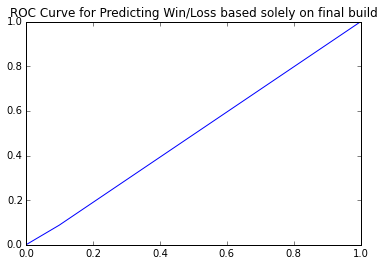

In [25]:
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='AUC: {0}'.format(auc))
plt.title("ROC Curve for Predicting Win/Loss based solely on final build")
plt.show()

So the third hypothesis seems likely. Linear SVM does *really* badly on this. 267 binary features isn't even that many.